In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import snap
import matplotlib.pyplot as plt
import math

In [2]:
fileName = "clusters_full.csv"

In [114]:
def formatDf(df):
    df = df.loc[df.loc[:,(0)] != 0]
    #df[3] = df[3].apply(lambda a: a.split('=', 1)[-1][:-1])
    return df

In [112]:
testDf = pd.read_csv(fileName, nrows=20, header=None)

In [ ]:
testDf

In [ ]:
cleaned_final_cluster = "final_clusters_without_0.csv"
chunksize = 1000000
row = 0
print("started")
with open(cleaned_final_cluster, 'a') as f:
    for df in pd.read_csv(fileName, chunksize=chunksize, iterator=True, header=None, error_bad_lines=False, skiprows=130000000+9530000):
        print("Process Row number: %d" % row)
        df = formatDf(df)
        df.to_csv(f, header=False)
        row += chunksize
        print("Start Row number: %d" % row)
print("done")
    

started


In [21]:
def groupDf(df):
    return df[1].value_counts()

In [3]:
clusterCount = Counter()
row = 0
chunksize = 10000000
otc_cluster = "otc_scores_with_cluster.csv"
df = pd.read_csv(otc_cluster)

In [4]:
otc_dic = "otc_scores_dict.csv"
dicDf = pd.read_csv(otc_dic, header=None)

In [5]:
scoreDic = dicDf.set_index(0).to_dict()[1]

In [6]:
addrDf = df["address"].apply(lambda a: scoreDic.get(a,0))
df['score'] = addrDf

In [7]:
newdf = df[['cluster_id','score']].groupby('cluster_id').count()

In [150]:
df[df['address'] == "15Nw383QHazR8TtSj2wFvLTLFiCMBpqWXE"]

,cluster_size,cluster_id,address_id,address_type,address,address_num,score
497,291,1558677,5911030,pubkeyhash,15Nw383QHazR8TtSj2wFvLTLFiCMBpqWXE,5911030,-9


In [8]:
clusterScoreDf = df[['cluster_id','score']].groupby('cluster_id').mean()
clusterScoreDict = clusterScoreDf.to_dict()['score']
# Map from cluster to 
clusterScoreDict = Counter(clusterScoreDict)

In [ ]:
'''graph = snap.LoadEdgeList(snap.PNGraph, "cluster_links_without_0.csv", 0, 1, ',')
graph = snap.LoadEdgeList(snap.PNGraph, "transactions_from_interesting_users.csv", 0, 1, ',')
triads = snap.GetTriads(graph)'''

In [16]:
def bfsGraph(graph, graphName=""):
    forward = Counter()
    backward = Counter()
    for i in range(100):
        node = graph.GetRndNId()
        forwardBfs = snap.GetBfsTree(graph, node, True, False) # Follow out
        backwardBfs = snap.GetBfsTree(graph, node, False, True) # Follow in
        forward[forwardBfs.GetNodes()] += 1
        backward[backwardBfs.GetNodes()] += 1
    cumulative = 0.0
    cForward = Counter()
    for key in sorted(forward.keys()):
        cumulative += forward[key]
        cForward[key] = cumulative
    cumulative = 0.0
    cBackward = Counter()
    for key in sorted(backward.keys()):
        cumulative += backward[key]
        cBackward[key] = cumulative
        
    maximum = max(cForward.values()) * 1.0
    forwardValues = [0.0]
    forwardKeys = [0.0]
    for key in sorted(cForward.keys()):
        forwardKeys.append(key)
        forwardValues.append(cForward[key]/maximum)
    finalForwardKeys = [i for i in range(max(forwardKeys))]
    finalForwardValues = []
    lastValue = 0
    for i in finalForwardKeys:
        if i in cForward:
            lastValue = cForward[i]
        finalForwardValues.append(lastValue)
    
    maximum = max(cBackward.values()) * 1.0
    backwardValues = [0.0]
    backwardKeys = [0.0]
    for key in sorted(cBackward.keys()):
        backwardKeys.append(key)
        backwardValues.append(cBackward[key]/maximum)
        
    finalBackwardKeys = [i for i in range(max(backwardKeys))]
    finalBackwardValues = []
    lastValue = 0
    for i in finalBackwardKeys:
        if i in cBackward:
            lastValue = cBackward[i]
        finalBackwardValues.append(lastValue)
    
        
    plt.title("Reachability using outlinks " + graphName)
    plt.plot(finalForwardValues, finalForwardKeys, marker='o')
    plt.yscale('log')
    plt.xlabel('Frac of starting nodes')
    plt.ylabel('Number of nodes reached')
    plt.show()
    plt.title("Reachability using inlinks " + graphName)
    plt.plot(finalBackwardValues, finalBackwardKeys, marker='o')
    plt.yscale('log')
    plt.xlabel('Frac of starting nodes')
    plt.ylabel('Number of nodes reached')
    plt.show()

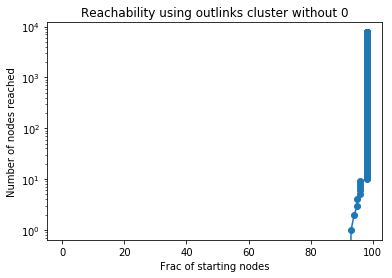

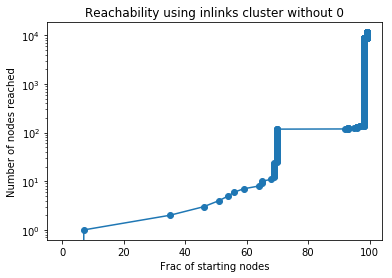

In [30]:
bfsGraph(graph, graphName="cluster without 0")

In [3]:
zero_graph_nodes = [(node.GetId(),i) for i, node in enumerate(graph.Nodes())]
graphMap = dict(zero_graph_nodes)

In [4]:
import scipy.sparse as sparse

In [5]:
def computePurity(guesses, actual):
    n = len(guesses)
    clusters = {}
    for i, guess in enumerate(guesses):
        if guess not in clusters:
            clusters[guess] = Counter({})
        clusters[guess][actual[i]] += 1
    count = 0.0
    for k in clusters:
        cluster = clusters[k]
        highestKey = max(cluster, key=cluster.get)
        highestValue = cluster[highestKey]
        count += highestValue
    return count/n*1.0

def createAdjacencyMatrix(Graph):
    nodeMap = [node.GetId() for i, node in enumerate(graph.Nodes())]
    adj = np.zeros((Graph.GetNodes(), Graph.GetNodes()))
    for node in Graph.Nodes():
        i = graphMap[node.GetId()]
        outEdges = node.GetOutEdges()
        for outEdgeNum in node.GetOutEdges():
            outEdge = graphMap[outEdgeNum]
            adj[i, outEdge] = 1.0
            adj[outEdge, i] = 1.0
    return adj

def createDegreeMatrix(Graph):
    deg = np.zeros((Graph.GetNodes(), Graph.GetNodes()))
    for node in Graph.Nodes():
        i = graphMap[node.GetId()]
        deg[i,i] = node.GetDeg()
    return deg

def createLaplacian(Graph):
    return np.subtract(createDegreeMatrix(Graph), createAdjacencyMatrix(Graph))

def spectralDecomp(Graph):
    a = createAdjacencyMatrix(Graph)
    length = np.shape(a)[0]
    d = np.matrix(np.dot(createDegreeMatrix(Graph), np.ones(length)))
    m = Graph.GetEdges()*2.0
    b = np.subtract(a, np.divide(np.dot(np.transpose(d),d),1.0/2.0*m))
    
    '''vals, vecs = sparse.linalg.eigs(b)
    
    maximizer = vecs[:,1]
    decision = []
    for entry in maximizer:
        if entry >= 0:
            decision.append(1)
        else:
            decision.append(0)
    return decision'''

In [ ]:
decisions = spectralDecomp(graph)

In [171]:
without_zero_cluster = "cluster_links_without_0.csv"
wzdf = pd.read_csv(without_zero_cluster, header=None)

In [142]:
graph = snap.LoadEdgeList(snap.PNGraph, "cluster_links_without_0.csv", 0, 1, ',')

In [143]:
graph.AddNode(0)
for node in graph.Nodes():
    if node.GetId() != 0:
        graph.AddEdge(0, node.GetId())
        graph.AddEdge(node.GetId(), 0)

In [ ]:
snap.PlotClustCf(graph, "clust_without_0", "Clusters without 0 - clustering coefficient")

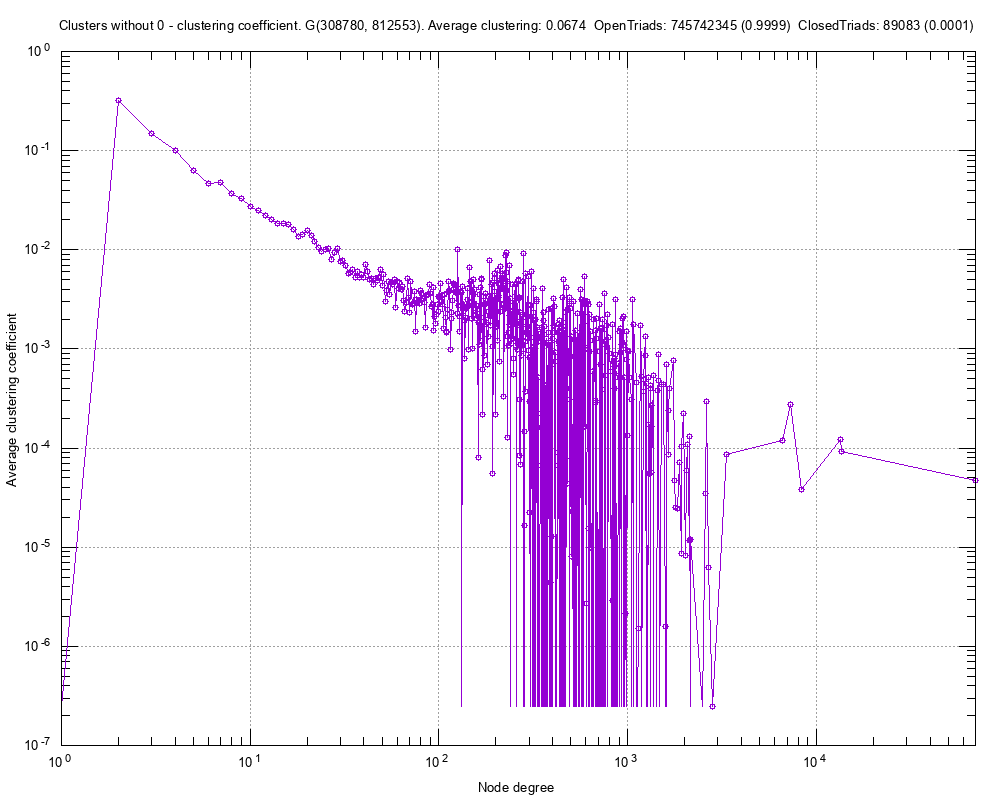

In [19]:
from IPython.display import Image
Image(filename='ccf.clust_without_0.png')

In [60]:
scoreCollection = Counter(scoreDic)

In [12]:
def calculateNegative(scores):
    total = 0
    for i in scores.values():
        if i < 0:
            total += 1
    print(total)
    
def normalize(scores):
    newScores = Counter({})
    for i in scores:
        if scores[i] > 0:
            newScores[i] = 1
        else:
            newScores[i] = -1
    return newScores
            
def propogateScore(scores, graph, alpha=0.5, beta=0.5):
    # beta = amount of score flowing out of node
    # alpha = amount of score kept in node
    # scores = map from node to score
    # graph = graph with nodes that match score keys
    newScores = Counter({})
    for nodeId, score in scores.iteritems():
        if (not graph.IsNode(nodeId)):
            graph.AddNode(nodeId)
            graph.AddEdge(nodeId,0)
            graph.AddEdge(0, nodeId)
        node = graph.GetNI(nodeId)
        if (node.GetOutDeg() == 0):
            graph.AddEdge(nodeId,0)
        newScores[nodeId] += score * alpha
        betaFlow = score*beta/(node.GetOutDeg())
        for neighborId in node.GetOutEdges():
            newScores[neighborId] += betaFlow
    return newScores

In [13]:
normalizeDict=normalize(clusterScoreDict)
newScores = propogateScore(normalizeDict, graph)

In [182]:
print(graph.GetNodes())
print(len(newScores))

309596
309596


In [9]:
interest = "tx_flows_of_interest_with_cluster_and_timestamp_v2.csv"
txnDf = pd.read_csv(interest)

In [23]:
txnDf[['from_cluster_id','to_cluster_id']].to_csv("transactions_from_interesting_users_v2.csv", header=False, index=False)

In [17]:
graph = snap.LoadEdgeList(snap.PNGraph, "transactions_from_interesting_users_v2.csv", 0, 1, ',') #combined_links_without_0_and_interest.csv

In [18]:
negativeNodes = [i for i in clusterScoreDict if clusterScoreDict[i] < 0

In [27]:
print(len(negativeNodes))

174


In [19]:
outNodeCounter = Counter({})
for node in negativeNodes:
    if node != 0:
        if graph.IsNode(node):
            outNodes = [i for i in graph.GetNI(node).GetOutEdges()]
            for i in outNodes:
                outNodeCounter[i] += 1
        else:
            print('not_found')

doubleOutNodeCounter = Counter({})
for node in outNodeCounter:
    if node != 0:
        outNodes = [i for i in graph.GetNI(node).GetOutEdges()]
        for i in outNodes:
            doubleOutNodeCounter[i] += 1
        
tripleOutNodeCounter = Counter({})
for node in doubleOutNodeCounter:
    if node != 0:
        outNodes = [i for i in graph.GetNI(node).GetOutEdges()]
        for i in outNodes:
            tripleOutNodeCounter[i] += 1

In [20]:
outNodeCounter = Counter({})
for node in negativeNodes:
    outNodeCounter[node] += 1
lastLen = 0

iterations = 0
while(lastLen < len(outNodeCounter)):
    iterations += 1
    lastLen = len(outNodeCounter)
    for node in outNodeCounter.keys():
        if node != 0:
            if graph.IsNode(node):
                outNodes = [i for i in graph.GetNI(node).GetOutEdges()]
                for i in outNodes:
                    outNodeCounter[i] += 1
            else:
                print('not_found')
                
print("iterations : %d" % iterations)

iterations : 4


In [22]:
len(outNodeCounter)

309

In [140]:
suspiciousClusters = []
for node in outNodeCounter:
    if outNodeCounter[node] > iterations:
        suspiciousClusters.append(node)
print(len(suspiciousClusters))
differentClusters = []
for node in suspiciousClusters:
    if node not in clusterScoreDict:
        differentClusters.append(node)
        
print(differentClusters)

for i in differentClusters:
    print(outNodeCounter[i])
        

40
[1563744, 1871384, 1659131, 1946245]
7
7
7
5


In [31]:
for node in suspiciousClusters:
    print node, (outNodeCounter[node]*1.0/graph.GetNI(node).GetInDeg())

0 0.0144241776692
1424929 0.227272727273
1563744 2.33333333333
1525819 1.25
3171424 2.5
1739958 0.555555555556
1315920 1.0
1251940 2.5
1497702 1.66666666667
1219694 0.625
2420337 2.5
1896079 0.833333333333
1871384 2.33333333333
1558677 0.324324324324
1703600 2.5
372403 1.25
1457695 1.25
1768133 0.714285714286
1580755 1.8
1659131 2.33333333333
2088704 2.5
1813764 1.6
1946245 2.5
1164597 0.16
1619261 0.238095238095
2178375 2.5
2215247 0.714285714286
1868649 0.833333333333
1602877 0.416666666667
1648500 1.25
535932 0.3125
1586053 1.66666666667
1458092 1.0
1536960 0.3125
566722 0.138888888889
1607619 0.714285714286
1578437 2.5
1995232 2.5
1922027 0.416666666667
1831923 1.66666666667


In [310]:
snap.PlotInDegDistr(graph, "indeg_combined", "Directed graph - in-degree Distribution")

In [311]:
snap.PlotOutDegDistr(graph, "outdeg_combined", "Directed graph - out-degree Distribution")

In [312]:
snap.PlotClustCf(graph, "clust_coeff_combined", "Directed graph - cluster coefficient")

In [67]:
without_zero_graph = snap.LoadEdgeList(snap.PNGraph, "cluster_links_without_0.csv", 0, 1, ',')
PRankH = snap.TIntFltH()
snap.GetPageRank(without_zero_graph, PRankH)

In [68]:
PRankH.SortByDat()
prankDict = {}
i = 0
for item in PRankH:
    prankDict[item] = PRankH[item]

In [69]:
sortedPrank = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)

In [189]:
# Page rank on clouster links without 0
def pageRankCalculate(graph, title="all non-zero clusters"):
    topIds = []
    for c in [0.01, 0.1, 0.5, 0.9, 0.99, 1.0]:
        PRankH = snap.TIntFltH()
        snap.GetPageRank(graph, PRankH, c)
        prankDict = {}
        for item in PRankH:
            prankDict[item] = PRankH[item]
        sortedPrank = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)
        plt.plot([i[1] for i in sortedPrank], [i/float(len(sortedPrank)) for i in range(len(sortedPrank))], label="Damping Factor %f" % c)
        topIds.extend([i[0] for i in sortedPrank[0:20]])
    newlist = []
    for i in topIds:
        if i not in newlist:
            newlist.append(i)
    print(newlist)
    plt.title('Page Rank Distribution on %s' % title)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Page Rank')
    plt.ylabel('CDF')
    plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
    plt.show()
    
def pageRankRegress(graph):
    PRankH = snap.TIntFltH()
    snap.GetPageRank(without_zero_graph, PRankH)
    prankDict = {}
    for item in PRankH:
        prankDict[item] = PRankH[item]
    sortedPrank = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)
    plt.plot([i[1] for i in sortedPrank], [i/float(len(sortedPrank)) for i in range(len(sortedPrank))], label="Page Rank")
    # Entire cluster
    x = [i[1] for i in sortedPrank]
    y = [(i+1)/float(len(sortedPrank)) for i in range(len(sortedPrank))]
    logx = np.log(x)
    logy = np.log(y)
    p = np.polyfit(logx,logy, 1)
    a = -1.0 * p[0]
    print("[Full] The value of a is %f" % a)
    lineX = [min(x), max(x)]
    lineY = np.exp([p[1]+p[0]*min(logx), p[1]+p[0]*max(logx)])
    plt.plot(lineX, lineY, label ="Full LSE", color = "g")
    plt.title('Page Rank Distribution on all non-zero clusters')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Page Rank')
    plt.ylabel('CDF')
    plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
    plt.show()

[87966336, 127783720, 391151, 4173414, 5967771, 127198065, 4177844, 4175767, 99524217, 8165960, 482495, 4177151, 354066, 715027, 263554, 5399237, 3736737, 4174618, 336366, 4171988, 144767942, 413141, 403145, 136304180, 2690704, 493743, 1029416, 136709175, 4140240, 279117, 727737, 451773, 4615131, 466522, 4376229]


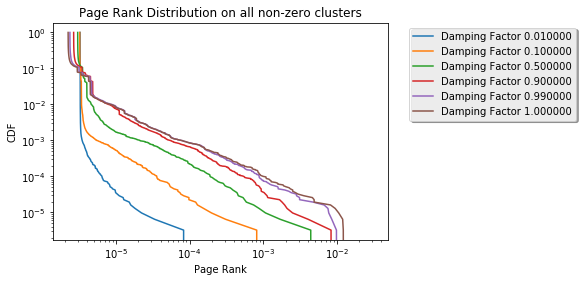

In [190]:
pageRankCalculate(without_zero_graph)

[Full] The value of a is 3.456373


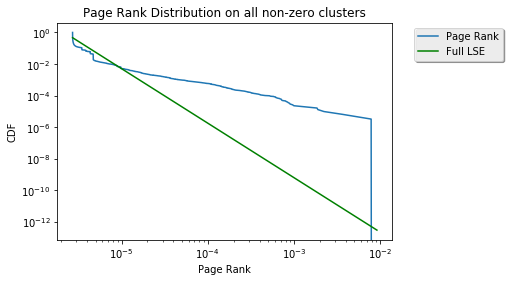

In [144]:
# http://chato.cl/papers/becchetti_06_distribution_pagerank_power_law_particular_damping_factor.pdf
pageRankRegress(without_zero_graph)

[Full] The value of a is 0.186963
[Tail] The value of a is 0.853879


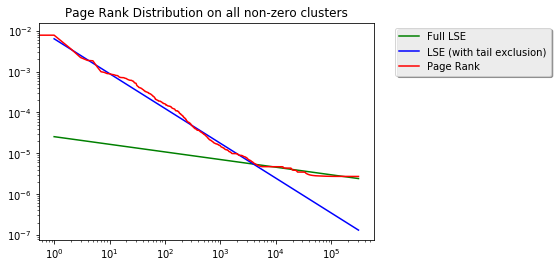

In [87]:
# Entire cluster
x = [i+1 for i in range(len(sortedPrank))]
y = [i[1] for i in sortedPrank]
logx = np.log(x)
logy = np.log(y)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("[Full] The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(logx)])
plt.plot(lineX, lineY, label ="Full LSE", color = "g")

xnew = [i+1 for i in range(4000)]
ynew = [i[1] for i in sortedPrank[0:len(xnew)]]
logx = np.log(xnew)
logy = np.log(ynew)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("[Tail] The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(np.log(x))])
plt.plot(lineX, lineY, label ="LSE (with tail exclusion)", color = "b")

plt.plot([i for i in range(len(sortedPrank))], [i[1] for i in sortedPrank], color="r", label="Page Rank")
    
plt.title('Page Rank Distribution on all non-zero clusters')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
plt.show()

# Page rank dampening -- different results from what we see here
# No truncation
# https://dl.acm.org/citation.cfm?doid=1135777.1135955

In [56]:
print(graph.GetNodes(), graph.GetEdges())

(846730, 1773587)


In [128]:
Graph = snap.GenRndGnm(snap.PNGraph, graph.GetNodes(), graph.GetEdges())
PRankH = snap.TIntFltH()
snap.GetPageRank(Graph, PRankH)
randGraph = Graph
PRankH.SortByDat()
prankDict = {}
i = 0
for item in PRankH:
    prankDict[item] = PRankH[item]
sortedPrankRandom = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)

The value of a is 0.633138


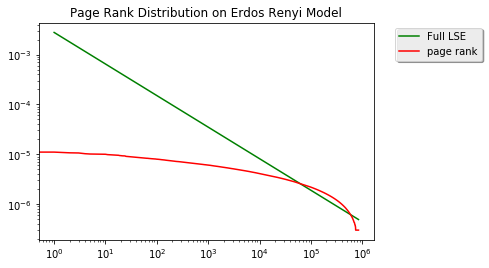

In [74]:
# Page rank on cluster links without 0

# Entire cluster
x = [i+1 for i in range(len(sortedPrankRandom))]
y = [i[1] for i in sortedPrankRandom]
logx = np.log(x)
logy = np.log(y)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(logx)])
plt.plot(lineX, lineY, label ="Full LSE", color = "g")

'''xnew = [i+1 for i in range(4000)]
ynew = [i[1] for i in sortedPrank[0:len(xnew)]]
logx = np.log(xnew)
logy = np.log(ynew)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(np.log(x))])
plt.plot(lineX, lineY, label ="LSE (with tail exclusion)", color = "g")'''

plt.plot([i for i in range(len(sortedPrankRandom))], [i[1] for i in sortedPrankRandom], color="r", label="page rank")
    
plt.title('Page Rank Distribution on Erdos Renyi Model')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
plt.show()

[797613, 191044, 612197, 322815, 798748, 463258, 474585, 226960, 288829, 591147, 92894, 50130, 252072, 199617, 40708, 389234, 194170, 308972, 610115, 651518, 80229, 61487, 671400, 745901, 20292, 154373, 575269, 772037, 89010, 674292, 545963, 63928, 652913, 190173, 761728, 344540, 191483, 385499, 424768, 230240, 692909, 211616, 805092, 72867, 83652, 297469, 656590, 186127, 282242, 648929, 485291, 216250, 388939, 289686, 654278, 802207, 34907, 134546]


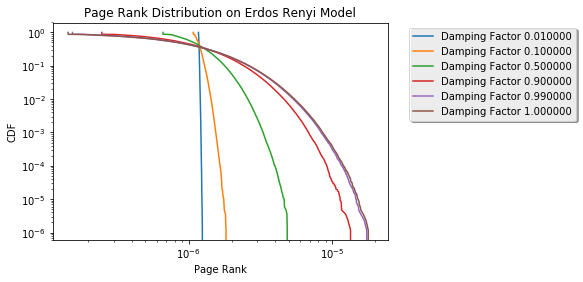

In [185]:
pageRankCalculate(randGraph, title="Erdos Renyi Model")

In [131]:
Rnd = snap.TRnd()
Graph = snap.GenPrefAttach(100, 10, Rnd)
prefAttachedGraph = Graph
PRankH = snap.TIntFltH()
snap.GetPageRank(Graph, PRankH)
PRankH.SortByDat()
prankDict = {}
i = 0
for item in PRankH:
    prankDict[item] = PRankH[item]
sortedPrankRandom = sorted(prankDict.iteritems(), key=lambda (k,v): (v,k), reverse=True)

[2, 7, 8, 9, 3, 10, 6, 11, 0, 21, 1, 4, 13, 12, 5, 14, 20, 19, 22, 25, 15]


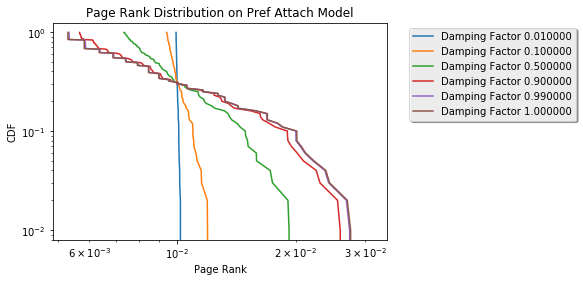

In [186]:
pageRankCalculate(prefAttachedGraph, title="Pref Attach Model")

The value of a is 0.427906


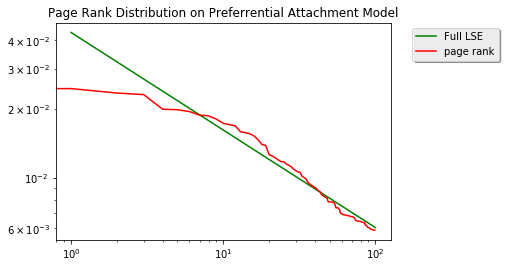

In [65]:
# Page rank on cluster links without 0

# Entire cluster
x = [i+1 for i in range(len(sortedPrankRandom))]
y = [i[1] for i in sortedPrankRandom]
logx = np.log(x)
logy = np.log(y)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(logx)])
plt.plot(lineX, lineY, label ="Full LSE", color = "g")

'''xnew = [i+1 for i in range(4000)]
ynew = [i[1] for i in sortedPrank[0:len(xnew)]]
logx = np.log(xnew)
logy = np.log(ynew)
p = np.polyfit(logx,logy, 1)
a = -1.0 * p[0]
print("The value of a is %f" % a)
lineX = [min(x), max(x)]
lineY = np.exp([p[1], p[1]+p[0]*max(np.log(x))])
plt.plot(lineX, lineY, label ="LSE (with tail exclusion)", color = "g")'''

plt.plot([i for i in range(len(sortedPrankRandom))], [i[1] for i in sortedPrankRandom], color="r", label="page rank")
    
plt.title('Page Rank Distribution on Preferrential Attachment Model')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2, shadow = True, bbox_to_anchor=(1.05, 1))
plt.show()